In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import minimize

In [2]:
from MI_CC_plot import all_plos

In [5]:
Ulbps = [20,40,100,150,200,300,400]
s_values = Ulbps
def pVav_numbers(current_path,Kp_condn,cluster_condn,HLA_cond,time):
    r_samples = {}
    for Ulbp in Ulbps:
        file_path = f'{current_path}/{Kp_condn}/{cluster_condn}/{HLA_cond}/Ulbp_{Ulbp}/pVav_number_w_time.csv'
        if os.path.exists(file_path):
            file_path = file_path
        else:
            file_path = f'{current_path}/{Kp_condn}/{cluster_condn}/{HLA_cond}/Ulbp_{Ulbp}/pVav_number_w_time_iter0.csv'
            #print(file_path)
        df = pd.read_csv(file_path, index_col=0)
        r_samples[Ulbp] = df[f'time_{time}'].values
    return r_samples
# Compute P(R|S)
def compute_P_rs(r_samples):
    probabilities = {}
    for s, r_vals in r_samples.items():
        unique_r, counts = np.unique(r_vals, return_counts=True)
        probabilities[s] = {r: count / len(r_vals) for r, count in zip(unique_r, counts)}
    return probabilities
def mutual_information(s_values, probabilities, p_s):
    """Computes mutual information I(S; R) given P(S), P(R|S)"""
    p_r = defaultdict(float)
    
    # Compute marginal output probability P(R)
    for s_idx, s in enumerate(s_values):
        for r, p_r_given_s in probabilities[s].items():
            p_r[r] += p_s[s_idx] * p_r_given_s

    mi = 0.0
    # Compute mutual information using MI formula
    for s_idx, s in enumerate(s_values):
        for r, p_r_given_s in probabilities[s].items():
            if p_s[s_idx] > 0 and p_r[r] > 0 and p_r_given_s > 0: # P(s), P(r), P(r|s) 
                mi += p_s[s_idx] * p_r_given_s * np.log2(p_r_given_s / p_r[r])
    return mi
def arimoto_blahut(s_values, probabilities, tol=1e-6, max_iters=1000):
    """Computes channel capacity using Arimoto-Blahut algorithm"""
    num_states = len(s_values)
    
    # Initialize input distribution P(S) uniformly
    p_s = np.full(num_states, 1 / num_states)
    
    prev_mi = 0.0
    for _ in range(max_iters):
        p_r = defaultdict(float)
        
        # Compute P(R)
        for s_idx, s in enumerate(s_values):
            for r, p_r_given_s in probabilities[s].items():
                p_r[r] += p_s[s_idx] * p_r_given_s

        # Update P(S) using Arimoto-Blahut rule
        new_p_s = np.zeros(num_states)
        for s_idx, s in enumerate(s_values):
            sum_term = 0.0
            for r, p_r_given_s in probabilities[s].items():
                if p_r_given_s > 0 and p_r[r] > 0:
                    sum_term += p_r_given_s * np.log2(p_r_given_s / p_r[r])
            new_p_s[s_idx] = p_s[s_idx] * np.exp2(sum_term)  # Use exp2 for base-2 exponentiation

        # Normalize P(S)
        new_p_s /= np.sum(new_p_s)

        # Compute Mutual Information
        mi = mutual_information(s_values, probabilities, new_p_s)

        # Check for convergence
        if abs(mi - prev_mi) < tol:
            break
        prev_mi = mi
        p_s = new_p_s
        #print("MI In:", mi)
    return mi, p_s  # Return the computed channel capacity and optimal P(S)

In [6]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0, 1) for _ in range(len(s_values))]
num_states = len(s_values)
p_s = np.full(num_states, 1 / num_states)
def mi_cc_matix(current_path,Kp_condns,cluster_condn,HLA_condns,time):
    mi_matrix = np.zeros((len(Kp_condns),len(HLA_condns)))
    cc_matrix = np.zeros_like(mi_matrix)
    for j,Kp_condn in enumerate(Kp_condns):
        for i, HLA_cond in enumerate(HLA_condns):
            r_samples = pVav_numbers(current_path,Kp_condn,cluster_condn,HLA_cond,time)
            probabilities = compute_P_rs(r_samples)
            mi = mutual_information(s_values, probabilities, p_s)
            #print("MI:", mi)
            cc, optimal_p_s = arimoto_blahut(s_values, probabilities)
            #print("Channel Capacity:", channel_capacity)
            #print("Optimal Input Distribution P(S):", optimal_p_s)
            mi_matrix[j,i] = mi
            cc_matrix[j,i] = cc
    return mi_matrix, cc_matrix

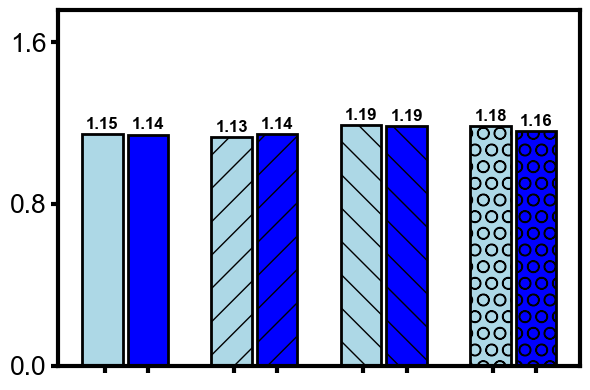

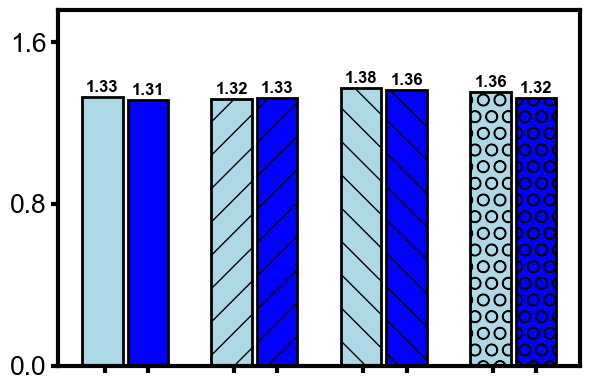

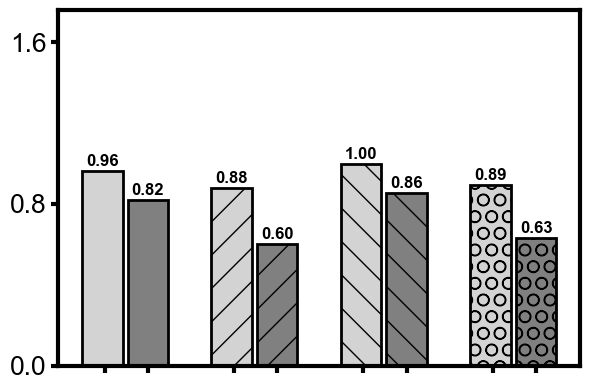

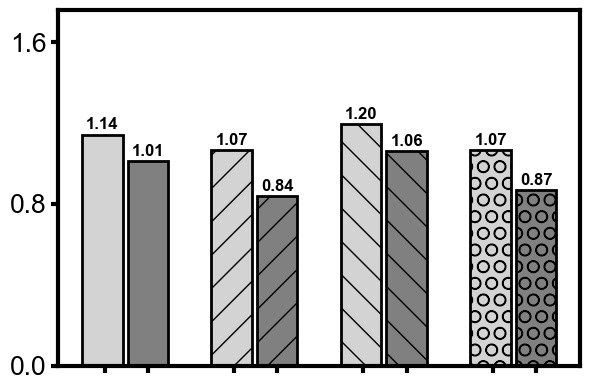

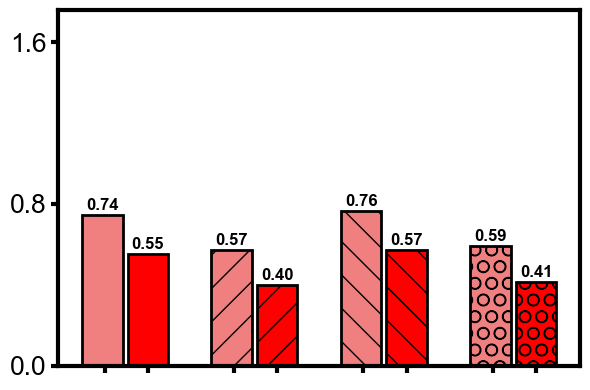

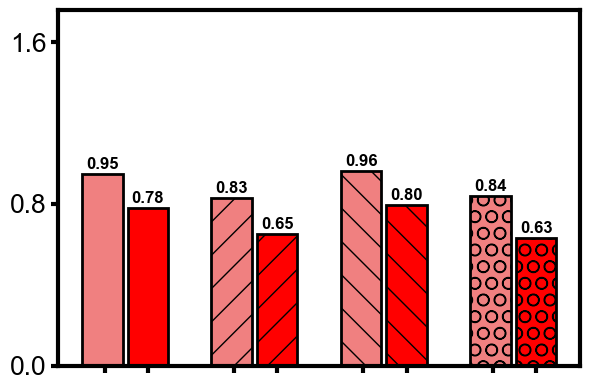

In [8]:
current_path = os.getcwd()
time = 20
Kp_condns = ['Kp_Both','No_Kp_Inh','No_Kp_Act','No_Kp']
cluster_condns = ['Disjoint','Homogeneous','Overlap']
HLA_condns = ['Low_HLA','High_HLA']
colors = np.array([['lightblue','blue'],['lightgray','gray'],['lightcoral','red']])
for cluster_condn,color in zip(cluster_condns,colors):
    mi_matrix, cc_matrix = mi_cc_matix(current_path,Kp_condns,cluster_condn,HLA_condns,time)
    all_plos(mi_matrix,cluster_condn,color,plot_info='MI')
    all_plos(cc_matrix,cluster_condn,color,plot_info='CC')